In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np

''' 
From "Transformers are RNNs: Fast Autoregressive Transformers with Linear Attention"
(https://arxiv.org/pdf/2006.16236)

We follow notation from the paper, eg. the matrices 'o' and 'n' as well as the recurrent formulation. 


Note. Neither approach uses a state (caching), so the inference times are quad/linear, resp. 
They would be linear/constant if we kept a KV cache in Softmax or state in LinearAttn. 
Nonethless, this suffices to see the O(S) speedup during inference going softmax -> linear attention. 
Our focus is on inference here, so we don't train/profile models with these, just fwd passes. 

The TLDR here is this: removing softmax makes us able to switch some order of operations to compute 
(Q@K.T)V = Q(K.T@V) by associativity of matrix multiplication here. The critical thing, which was not obvious to me 
until I thought about it, is that the right matmul is over dim S so is O(SD^2) whereas the left matmul is 
O(S^2D) and since S>>D often, we go from quadratic to linear in sequence length. The phi notation is just 
a generalization, you can essentially think of it as just dropping the softmax that would violate 
associativity and thus make the above equality fail.

'''

" Note. Neither approach uses a state (caching), so the inference times are quad/linear, resp. \nThey would be linear/constant if we kept a KV cache in Softmax or state in LinearAttn. \nNonethless, this suffices to see the O(S) speedup during inference going softmax -> linear attention. \nOur focus is on inference here, so we don't train/profile models with these, just fwd passes. "

In [12]:
# [Training] TIME: O(S^2), MEM: O(S) w/ FlashAttn and O(S^2) without
    # Note. It's the online softmax trick that gives asymptotic gains in FlashAttn
    # and obviously not any systems tricks, which (while important) only affect constant factors
# [Inference] TIME: O(S), MEM: O(S) w/ KV cache and O(S^2) without
class SoftmaxAttention(nn.Module): # single head for now 
    def __init__(self, D=256): 
        super().__init__()
        self.D = D
        self.scale = torch.sqrt(torch.tensor(D, dtype=torch.float32))
        self.wq = nn.Linear(D, D)
        self.wk = nn.Linear(D, D)
        self.wv = nn.Linear(D, D)
        self.wo = nn.Linear(D, D)

    def forward(self, x): # x is [B, S, D]
        Q, K, V = self.wq(x), self.wk(x), self.wv(x)
        A_logits = (Q @ K.transpose(1, 2))/self.scale
        A = F.softmax(A_logits, dim=-1) # [B, S, S], apply softmax on the last dimension
        return self.wo(A@V) # A@V is [B, S, D]

# [Training] TIME: O(S), MEM: O(S)
# [Inference] TIME: O(1), MEM: O(1)
class LinearAttention(nn.Module): 
    def __init__(self, D=256): 
        super().__init__()
        self.D = D 
        self.wq = nn.Linear(D, D)
        self.wk = nn.Linear(D, D)
        self.wv = nn.Linear(D, D)
        self.wo = nn.Linear(D, D)
        self.phi = lambda x: F.elu(x) + 1

    def forward(self, x): # x is [B, S, D]
        # get Q, K, V projections
        Q, K, V = self.wq(x), self.wk(x), self.wv(x)
        
        # apply feature map phi, see paper 
        Q_phi = self.phi(Q)  # [B, S, D]
        K_phi = self.phi(K)  # [B, S, D]
        
        # kv_accum and norm_accum via einsum 
        kv_accum = torch.einsum('bsd,bse->bde', K_phi, V) # BSD @ BSD -> BDD
        norm_accum = torch.sum(K_phi, dim=1) # [B, D]

        # o via einsum 
        o = torch.einsum('bsd,bde->bse', Q_phi, kv_accum) # BSD @ BDD -> BSD
        
        # normalization factor - correct shape handling
        norm_factor = torch.einsum('bsd,bd->bs', Q_phi, norm_accum).unsqueeze(-1) # [B, S, 1]
        
        return self.wo(o/norm_factor)



In [13]:
def benchmark_attention_mechanisms(batch_sizes=[1, 256], seq_lengths=[32, 128, 256, 512, 1024, 2048, 4096], device='cuda', num_runs=5):
    results = {}
    
    for batch_size in batch_sizes:
        results[batch_size] = {
            'seq_lengths': seq_lengths,
            'linear_times': [],
            'softmax_times': [],
            'linear_oom': [],
            'softmax_oom': []
        }
        
        # Initialize models
        linear_attn = LinearAttention().to(device)
        softmax_attn = SoftmaxAttention().to(device)
        
        for seq_len in tqdm(seq_lengths, desc=f"Benchmarking attention mechanisms (B={batch_size})"):
            # Create random input tensor
            x = torch.randn(batch_size, seq_len, 256, device=device)
            
            # Warm-up
            try:
                with torch.no_grad():
                    linear_attn(x)
            except torch.cuda.OutOfMemoryError:
                pass
                
            try:
                with torch.no_grad():
                    softmax_attn(x)
            except torch.cuda.OutOfMemoryError:
                pass
            
            # Benchmark LinearAttention
            torch.cuda.synchronize()
            linear_times = []
            linear_oom = False
            try:
                for _ in range(num_runs):
                    start_time = time.time()
                    with torch.no_grad():
                        linear_attn(x)
                    torch.cuda.synchronize()
                    linear_times.append(time.time() - start_time)
                avg_linear_time = np.mean(linear_times)
                results[batch_size]['linear_times'].append(avg_linear_time)
                results[batch_size]['linear_oom'].append(False)
            except torch.cuda.OutOfMemoryError:
                results[batch_size]['linear_times'].append(None)
                results[batch_size]['linear_oom'].append(True)
                torch.cuda.empty_cache()
            
            # Benchmark SoftmaxAttention
            torch.cuda.synchronize()
            softmax_times = []
            softmax_oom = False
            try:
                for _ in range(num_runs):
                    start_time = time.time()
                    with torch.no_grad():
                        softmax_attn(x)
                    torch.cuda.synchronize()
                    softmax_times.append(time.time() - start_time)
                avg_softmax_time = np.mean(softmax_times)
                results[batch_size]['softmax_times'].append(avg_softmax_time)
                results[batch_size]['softmax_oom'].append(False)
            except torch.cuda.OutOfMemoryError:
                results[batch_size]['softmax_times'].append(None)
                results[batch_size]['softmax_oom'].append(True)
                torch.cuda.empty_cache()
            
    return results

# different batch sizes/seqlens represent different kinds of workloads that need to be 
# accomodated in practice when serving many users 
batch_sizes = [1, 64, 1024]
seqlens = [32, 128, 512, 2048, 8192, 16384]
results = benchmark_attention_mechanisms(batch_sizes, seqlens)

# run next cell to see plots from these results!

Benchmarking attention mechanisms (B=1):   0%|                                                                                              | 0/6 [00:00<?, ?it/s]

Benchmarking attention mechanisms (B=1024): 100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


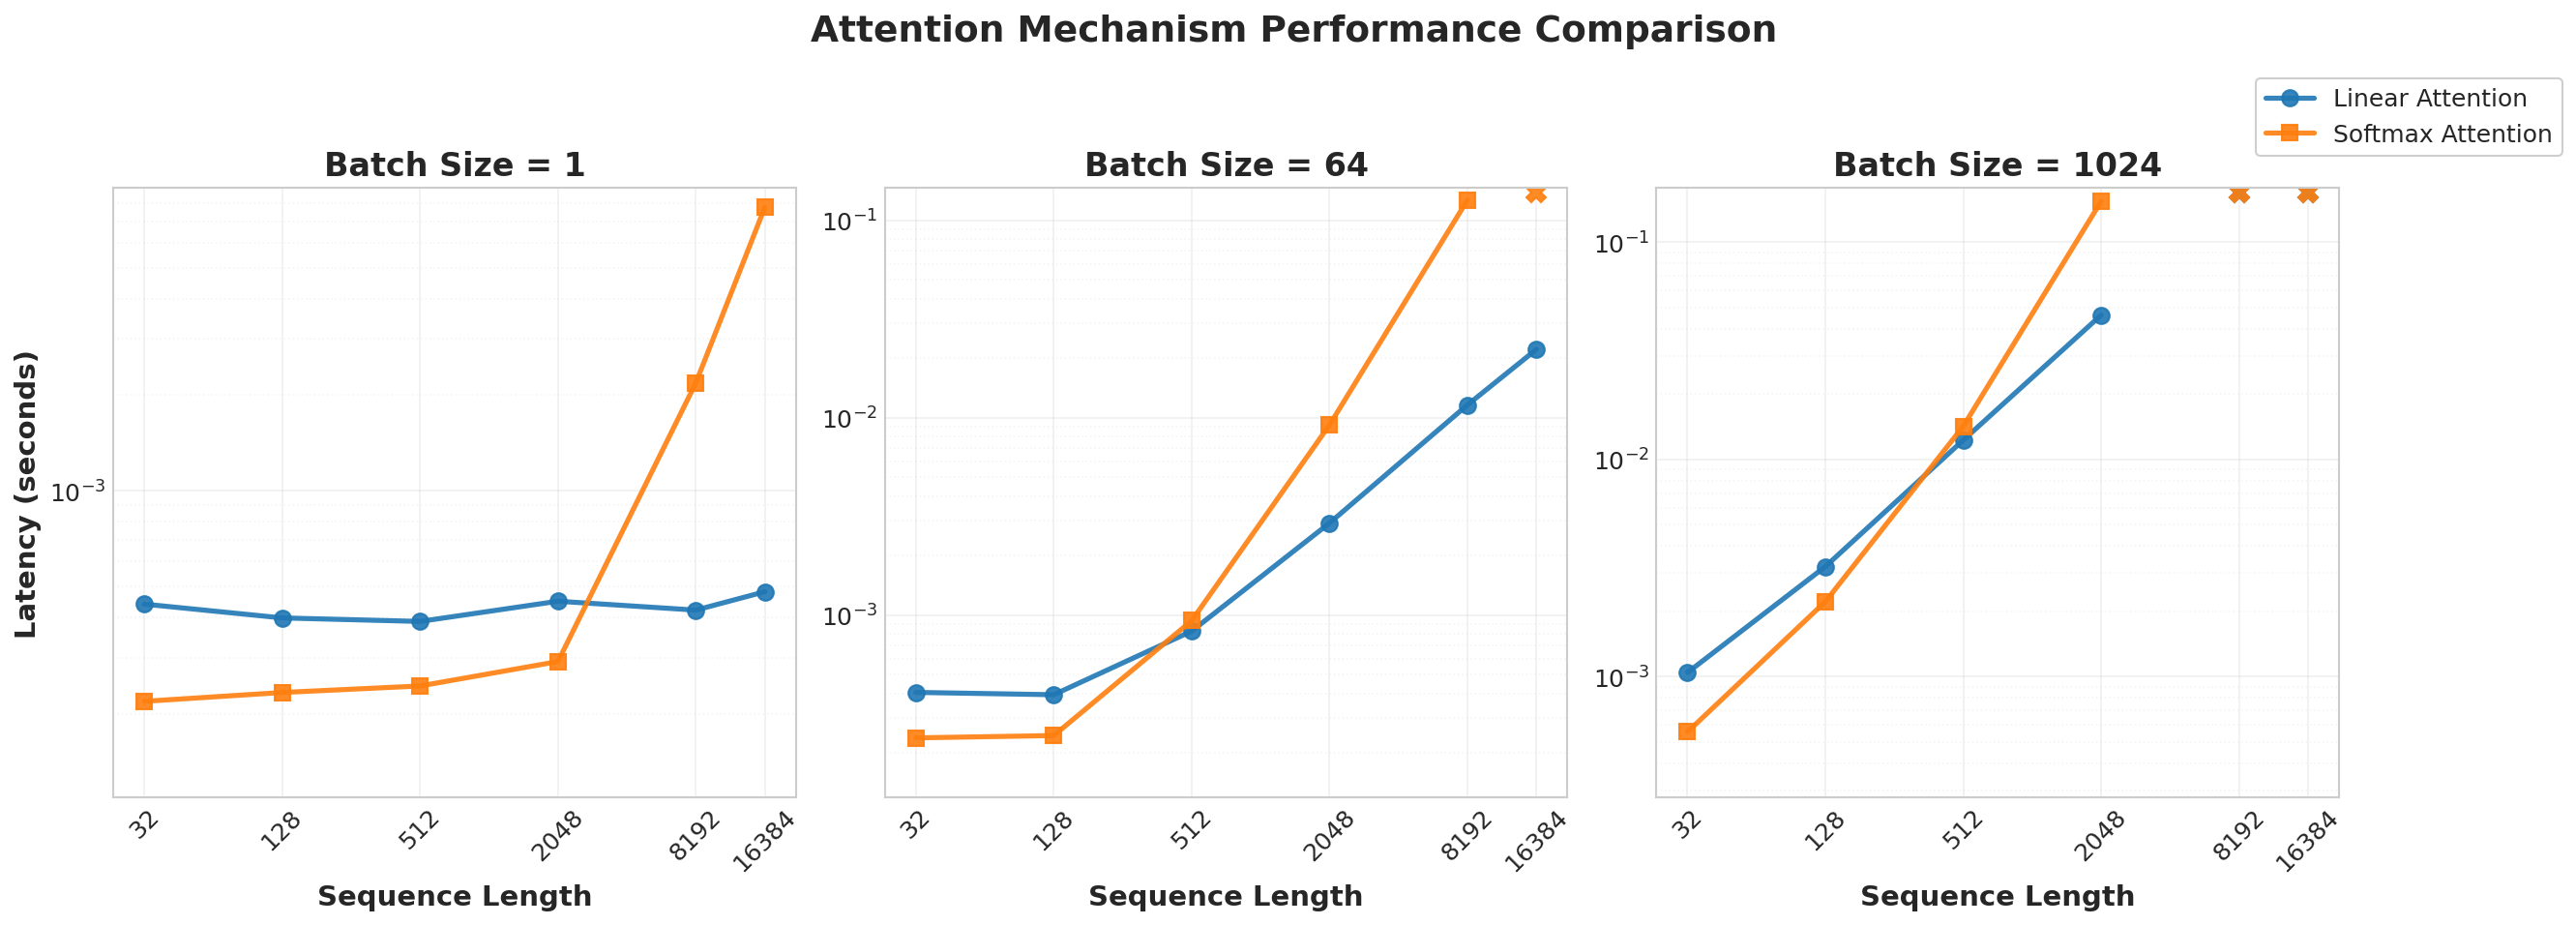

In [ ]:
# plotting infra, not important
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

fig, axes = plt.subplots(1, len(batch_sizes), figsize=(18, 6), dpi=150)

linear_color = '#1f77b4'
softmax_color = '#ff7f0e'
linear_marker = 'o'
softmax_marker = 's'
oom_marker = 'X'
marker_size = 8
line_width = 2.5

legend_handles = []
legend_labels = []

for i, batch_size in enumerate(batch_sizes):
    ax = axes[i]
    seq_lengths = results[batch_size]['seq_lengths']
    linear_times = results[batch_size]['linear_times']
    softmax_times = results[batch_size]['softmax_times']
    linear_oom = results[batch_size]['linear_oom']
    softmax_oom = results[batch_size]['softmax_oom']
    
    valid_linear_indices = [i for i, oom in enumerate(linear_oom) if not oom]
    valid_softmax_indices = [i for i, oom in enumerate(softmax_oom) if not oom]
    
    valid_linear_seqlens = [seq_lengths[i] for i in valid_linear_indices]
    valid_linear_times = [linear_times[i] for i in valid_linear_indices]
    
    valid_softmax_seqlens = [seq_lengths[i] for i in valid_softmax_indices]
    valid_softmax_times = [softmax_times[i] for i in valid_softmax_indices]
    
    line1, = ax.plot(valid_linear_seqlens, valid_linear_times, marker=linear_marker, 
            linestyle='-', linewidth=line_width, markersize=marker_size,
            color=linear_color, label='Linear Attention', alpha=0.9)
    
    line2, = ax.plot(valid_softmax_seqlens, valid_softmax_times, marker=softmax_marker, 
            linestyle='-', linewidth=line_width, markersize=marker_size,
            color=softmax_color, label='Softmax Attention', alpha=0.9)
    
    if i == 0:
        legend_handles.append(line1)
        legend_handles.append(line2)
        legend_labels.append('Linear Attention')
        legend_labels.append('Softmax Attention')
    
    oom_linear_indices = [i for i, oom in enumerate(linear_oom) if oom]
    oom_softmax_indices = [i for i, oom in enumerate(softmax_oom) if oom]
    
    oom_linear_seqlens = [seq_lengths[i] for i in oom_linear_indices]
    oom_softmax_seqlens = [seq_lengths[i] for i in oom_softmax_indices]
    
    ax.set_ylim(bottom=min([t for t in valid_linear_times + valid_softmax_times if t is not None]) * 0.5)
    y_max = ax.get_ylim()[1] * 1.1
    ax.set_ylim(top=y_max)
    
    if oom_linear_seqlens:
        line3, = ax.plot(oom_linear_seqlens, [y_max * 0.95] * len(oom_linear_seqlens), 
                marker=oom_marker, linestyle='', markersize=marker_size+2, 
                color=linear_color, label='Linear Attention OOM', alpha=0.9)
        if i == 0:
            legend_handles.append(line3)
            legend_labels.append('Linear Attention OOM')
    
    if oom_softmax_indices:
        line4, = ax.plot(oom_softmax_seqlens, [y_max * 0.95] * len(oom_softmax_seqlens), 
                marker=oom_marker, linestyle='', markersize=marker_size+2, 
                color=softmax_color, label='Softmax Attention OOM', alpha=0.9)
        if i == 0:
            legend_handles.append(line4)
            legend_labels.append('Softmax Attention OOM')
    
    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    ax.set_xlabel('Sequence Length', fontweight='bold')
    
    if i == 0:
        ax.set_ylabel('Latency (seconds)', fontweight='bold')
    
    ax.set_title(f'Batch Size = {batch_size}', fontweight='bold')
    
    ax.grid(True, which='major', linestyle='-', alpha=0.3)
    ax.grid(True, which='minor', linestyle=':', alpha=0.2)
    
    ax.set_xticks(seq_lengths)
    ax.set_xticklabels([str(s) for s in seq_lengths], rotation=45)

fig.legend(legend_handles, legend_labels, 
           loc='upper right', bbox_to_anchor=(0.99, 0.99),
           frameon=True, fancybox=True, framealpha=0.95)

fig.suptitle('Attention Mechanism Performance Comparison', fontweight='bold', y=1.05)

# This is a BEAUTIFUL PLOT IMO 
# the plot shows a comparison of linear vs softmax attention performance across different sequence lengths and batch sizes
# we can see that linear attention (blue) scales much better with sequence length than softmax attention (orange)
# for batch size 1, linear attention maintains nearly constant latency while softmax grows quadratically
# at larger batch sizes (64, 1024) the difference is less dramatic but linear attention still wins
# the X markers indicate out-of-memory (OOM) errors - softmax hits OOM earlier due to quadratic memory usage
# this empirically validates the theoretical O(N) vs O(N^2) complexity difference between the mechanisms

plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15, right=0.9)
plt.show()
